In [1]:
import Rwire_to_accuracy_lib as rtl
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import torch.nn.functional as F
import gc

In [2]:
#测试集与处理方案
dataset_train = torchvision.datasets.MNIST(root='./all_dataset',train=True,transform=transforms.ToTensor(),download=False)
dataset_test = torchvision.datasets.MNIST(root='./all_dataset',train=False,transform=transforms.ToTensor(),download=False)

dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train,batch_size=200,shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test,batch_size=1,shuffle=False)

In [11]:
PATH = './MLP784_100_10q8_1tanh5x.pt'
model_param = torch.load(PATH)

fc1_weight = model_param['fc1.weight']
fc1_bias = model_param['fc1.bias']
fc2_weight = model_param['fc2.weight']
fc2_bias = model_param['fc2.bias']
w_factor = 1.3968

Rm_min, Rm_max, Rm_off = 10e3, 50e3, 10e9
xbar_row, xbar_column = 128,128
R_row, R_column = 20,20
print('xbarsize: ',xbar_row,'  R_line: ',R_row)

xbarsize:  128   R_line:  20


In [12]:
fc1_weight = fc1_weight.cpu()
fc1_bias = fc1_bias.cpu()
fc2_weight = fc2_weight.cpu()
fc2_bias = fc2_bias.cpu()

start = time.time()
# C1 生成A逆
G_fc1p,G_fc1n = rtl.W_to_G(fc1_weight, fc1_bias, Rm_min, Rm_max, Rm_off, xbar_row, xbar_column, linear=False)
G_fc1p = G_fc1p.cuda()
G_fc1n = G_fc1n.cuda()
A_fc1p_inv = rtl.matrix_Ainv_generate_big_cuda(G_fc1p,R_row,R_column)
A_fc1n_inv = rtl.matrix_Ainv_generate_big_cuda(G_fc1n,R_row,R_column)
print(A_fc1p_inv.shape,A_fc1n_inv.shape)


G_fc2p,G_fc2n = rtl.W_to_G(fc2_weight, fc2_bias, Rm_min, Rm_max, Rm_off, xbar_row, xbar_column, linear=False)
G_fc2p = G_fc2p.cuda()
G_fc2n = G_fc2n.cuda()
A_fc2p_inv = rtl.matrix_Ainv_generate_big_cuda(G_fc2p,R_row,R_column)
A_fc2n_inv = rtl.matrix_Ainv_generate_big_cuda(G_fc2n,R_row,R_column)
print(A_fc2p_inv.shape,A_fc2n_inv.shape)

end0 = time.time()
print(end0-start)

torch.Size([7, 1, 33024, 128]) torch.Size([7, 1, 33024, 128])
torch.Size([1, 1, 33024, 128]) torch.Size([1, 1, 33024, 128])
175.00136542320251


In [13]:
vsource = 0.3
vin_level = 2**7-1  #8bit  对应正负输入电压范围
h_level = 2**7-1
delta_v = vsource/vin_level
delta_g = (1/Rm_min-1/Rm_max)/h_level
delta_i = delta_v*delta_g
w_scale = 1/(1/Rm_min-1/Rm_max)

error_idx = []
fm_set_before = []
fm_set_after = []
correct = 0
start = time.time()
for batch,(img,label) in enumerate(dataloader_test):
    img = img.cuda()
    label = label.cuda()

    #fc1
    z_set_fc1 = rtl.vector_z_generate_linear_cuda(img.reshape(-1),xbar_row,xbar_column,bias=True)  #第一次输入范围[0，1]
    #输入8bit量化
    z_set_fc1 = (z_set_fc1*vin_level).round()*delta_v 
    #连续输入输出
    # z_set_fc1 = z_set_fc1*vsource
    
    Iout_fc1p = rtl.linear_forward_cuda(A_fc1p_inv,z_set_fc1,G_fc1p.shape,R_column,out_neuron_num=100)
    Iout_fc1n = rtl.linear_forward_cuda(A_fc1n_inv,z_set_fc1,G_fc1n.shape,R_column,out_neuron_num=100)
    # if batch==99:
    #     fm1 = (Iout_fc1p-Iout_fc1n)/vsource*w_scale*w_factor
    #     print(fm1)
    Iout_fc1 = Iout_fc1p-Iout_fc1n
    
    fm_set_before += (Iout_fc1/vsource*w_scale*w_factor).tolist()
    Iout_fc1 = F.tanh(5*(Iout_fc1/vsource*w_scale*w_factor))
    fm_set_after += (Iout_fc1).tolist()
    
    z_set_fc2 = rtl.vector_z_generate_linear_cuda(Iout_fc1,xbar_row,xbar_column,bias=True)
    #输入8bit量化
    z_set_fc2 = (z_set_fc2*vin_level).round()*delta_v
    #连续输入输出
    # z_set_fc2 = z_set_fc2*vsource

    Iout_fc2p = rtl.linear_forward_cuda(A_fc2p_inv,z_set_fc2,G_fc2p.shape,R_column,out_neuron_num=10)
    Iout_fc2n = rtl.linear_forward_cuda(A_fc2n_inv,z_set_fc2,G_fc2n.shape,R_column,out_neuron_num=10)
    Iout_fc2 = (Iout_fc2p-Iout_fc2n).reshape(1,10)
    
    # print(Iout_fc1.shape)
    # end6 = time.time()
    # print('fc1:',end6-end5)
    value,idx = torch.max(Iout_fc2,1)
    correct += (idx==label).sum()
    if idx != label:
        error_idx.append(batch)
    # if (batch%100) == 0:
    #     print(batch)
    #     print('label=',label)
    #     print(idx)
    # end = time.time()
    # print('total:',end-start)
print('correct = ',correct)
end = time.time()
print(end-start)

correct =  tensor(7908, device='cuda:0')
11.561659812927246


In [6]:
#######保存 0.01Ω 激活前后情况############
fm_before_001 = fm_set_before
fm_after_001 = fm_set_after
print(len(fm_before_001),len(fm_after_001))
print(max(fm_before_001),max(fm_after_001))

1000000 1000000
28.15846824645996 1.0


In [6]:
#######保存 5Ω 激活前后情况############
fm_before_5 = fm_set_before
fm_after_5 = fm_set_after
print(len(fm_before_5),len(fm_after_5))
print(max(fm_before_5),max(fm_after_5))

1000000 1000000
3.369267225265503 1.0


In [10]:
#######保存 10Ω 激活前后情况############
fm_before_10 = fm_set_before
fm_after_10 = fm_set_after
print(len(fm_before_10),len(fm_after_10))
print(max(fm_before_10),max(fm_after_10))

1000000 1000000
2.4143223762512207 1.0


In [14]:
#######保存 20Ω 激活前后情况############
fm_before_20 = fm_set_before
fm_after_20 = fm_set_after
print(len(fm_before_20),len(fm_after_20))
print(max(fm_before_20),max(fm_after_20))

1000000 1000000
1.6200371980667114 0.9999998211860657


In [17]:
class MLP1(nn.Module):
    def __init__(self):
        super(MLP1,self).__init__()
        self.fc1 = nn.Linear(28*28,100)
        self.fc2 = nn.Linear(100,10)
        
    def forward(self,x):
        x = F.tanh(5*(self.fc1(x)*w_factor))
        x = self.fc2(x)
        return x

    def get_fm(self,x):
        x = self.fc1(x)*w_factor
        fm_before = x.detach()
        x = F.tanh(5*x)
        fm_after = x.detach()
        x = self.fc2(x)
        return fm_before,fm_after


#####识别率验证############    
# model1 = MLP1()
# model_param1 = torch.load('./MLP784_100_10q8_1tanh5x.pt')
# model1.load_state_dict(model_param1)

# correct = 0    
# for j, (images, labels) in enumerate(dataloader_test):
#     images = images.reshape(images.shape[0],-1)
#     images = (images)
#     pred = model1(images)
#     values,indices = torch.max(pred,1)
#     correct += (indices==labels).sum()
# print(correct)


#######保存 0Ω 激活前后情况############
fm_before_0 = []
fm_after_0 = []
for j, (images, labels) in enumerate(dataloader_test):
    images = images.reshape(images.shape[0],-1)
    images = (images)
    fmb,fma = model1.get_fm(images)
    fmb = fmb.reshape(-1)
    fma = fma.reshape(-1)    
    fm_before_0 += fmb.tolist()
    fm_after_0 += fma.tolist()
    
print(len(fm_before_0),len(fm_after_0))
print(max(fm_before_0),max(fm_after_0))

1000000 1000000
7.407891750335693 1.0


/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

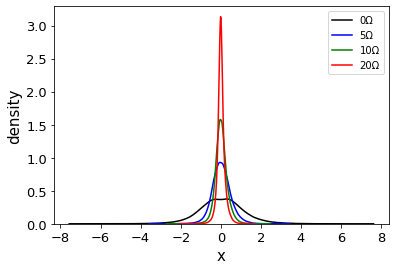

In [20]:
# print(len(fm_set_before),len(fm_set_after))
# print(max(fm_set_before),max(fm_set_after))
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(fm_before_0,hist=False,color = 'black',kde_kws={'label':'0Ω'})
sns.distplot(fm_before_5,hist=False,color = 'blue',kde_kws={'label':'5Ω'})
sns.distplot(fm_before_10,hist=False,color = 'green',kde_kws={'label':'10Ω'})
sns.distplot(fm_before_20,hist=False,color = 'red',kde_kws={'label':'20Ω'})
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.xlabel('x',fontsize='15')
plt.ylabel('density',fontsize='15')
plt.legend()
plt.savefig('./1tanh5x_before.jpg')
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator


model_param_02 = torch.load('./MLP784_100_10q8_tanh0.2x_9769.pt')
tanh02_weight = np.concatenate((model_param_02['fc1.weight'].reshape(-1), model_param_02['fc1.bias'].reshape(-1), 
                               model_param_02['fc2.weight'].reshape(-1), model_param_02['fc2.bias'].reshape(-1)),axis=0)
print(tanh02_weight.shape)

model_param_1 = torch.load('./MLP784_100_10q8_tanhx_9796.pt')
tanh1_weight = np.concatenate((model_param_1['fc1.weight'].reshape(-1), model_param_1['fc1.bias'].reshape(-1), 
                               model_param_1['fc2.weight'].reshape(-1), model_param_1['fc2.bias'].reshape(-1)),axis=0)
print(tanh1_weight.shape)

model_param_5 = torch.load('./MLP784_100_10q8_tanh5x_9760.pt')
tanh5_weight = np.concatenate((model_param_5['fc1.weight'].reshape(-1), model_param_5['fc1.bias'].reshape(-1), 
                               model_param_5['fc2.weight'].reshape(-1), model_param_5['fc2.bias'].reshape(-1)),axis=0)
print(tanh5_weight.shape)

(79510,)
(79510,)
(79510,)


D:\anaconda\envs\Data_analyse\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\Data_analyse\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\envs\Data_analyse\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

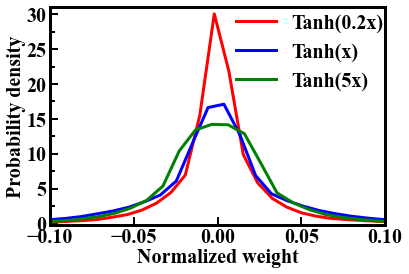

In [3]:
axes = plt.subplot()

axes.minorticks_on()
# 显示副刻度线
axes.tick_params(axis="both", which="major", direction="in", width=2, length=8)
axes.tick_params(axis="both", which="minor", direction="in", width=2, length=5)
# 设置主、副刻度线参数
axes.xaxis.set_minor_locator(MultipleLocator(0.2))
axes.yaxis.set_minor_locator(MultipleLocator(2.5))

# 设置 X 轴上的副刻度线之间的间隔为0.4

###设置坐标轴的粗细
ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(3);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(3);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(3);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(3);####设置上部坐标轴的粗细

font1 = {'family' : 'Times New Roman','weight' : 'bold','size'  : 20}
ax.set_xlabel('Normalized weight',font1,labelpad=0.5)
ax.set_ylabel('Probability density',font1,labelpad=0.5)
plt.xticks(fontproperties = 'Times New Roman',size = 20,weight = 'bold')
plt.yticks(fontproperties = 'Times New Roman',size = 20,weight = 'bold')


sns.distplot(tanh02_weight,hist=False,color = 'red',kde_kws={'label':'Tanh(0.2x)','linewidth':3})
sns.distplot(tanh1_weight,hist=False,color = 'blue',kde_kws={'label':'Tanh(x)','linewidth':3})
sns.distplot(tanh5_weight,hist=False,color = 'green',kde_kws={'label':'Tanh(5x)','linewidth':3})



plt.legend(bbox_to_anchor = (1.05,1.05),loc = 'upper right', frameon=False,prop={"family": "Times New Roman", "size": 20,'weight':'bold'})
ax.set_xticks([-0.1,-0.05,0,0.05,0.1])
plt.xlim(-0.1,0.1)
plt.ylim(-0.2,31)

# plt.savefig('./tanh_weight_distribution_test.tif', bbox_inches = 'tight',dpi=300)
plt.show()